In [1]:
%matplotlib notebook
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
import mre_pinn

torch.cuda.is_available()

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
C:\miniforge3\envs\MRE-PINN\lib\site-packages\ufl\__init__.py:245: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


PINN training will work normally. Only FEM baseline comparisons are disabled.


False

Download the BIOQIC simulation data set and convert it to xarray format.

In [3]:
bioqic = mre_pinn.data.BIOQICFEMBox('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/fem_box')

File already exists at ..\data\BIOQIC\downloads\four_target_phantom.mat, skipping download
Use force=True to re-download
Loading ..\data\BIOQIC\downloads\four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
<xarray.Dataset> Size: 23MB
Dimensions:    (frequency: 6, x: 80, y: 100, z: 10, component: 3)
Coordinates:
  * frequency  (frequency) int32 24B 50 60 70 80 90 100
  * x          (x) float64 640B 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y          (y) float64 800B 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
  * z          (z) float64 80B 0.0 0.001 0.002 0.003 ... 0.006 0.007 0.008 0.009
  * component  (component) <U1 12B 'y' 'x' 'z'
Data variables:
    wave       (frequency, x, y, z, component) complex128 23MB (0.00180392876...
Segmenting spatial regions
Creating ground truth elastogram
Writing ..\data\BIOQIC\fem_box\50\wave.nc
Writing ..\data\BIOQ

Visualize the wave field and display spatial metadata and descriptive statistics. Note that the z component of the wave field has the highest displacement amplitude. You can view the different components by adjusting the component slider.

Loading ..\data\BIOQIC\fem_box\90\wave.nc
Loading ..\data\BIOQIC\fem_box\90\mre.nc
Loading ..\data\BIOQIC\fem_box\90\mre_mask.nc


<IPython.core.display.Javascript object>


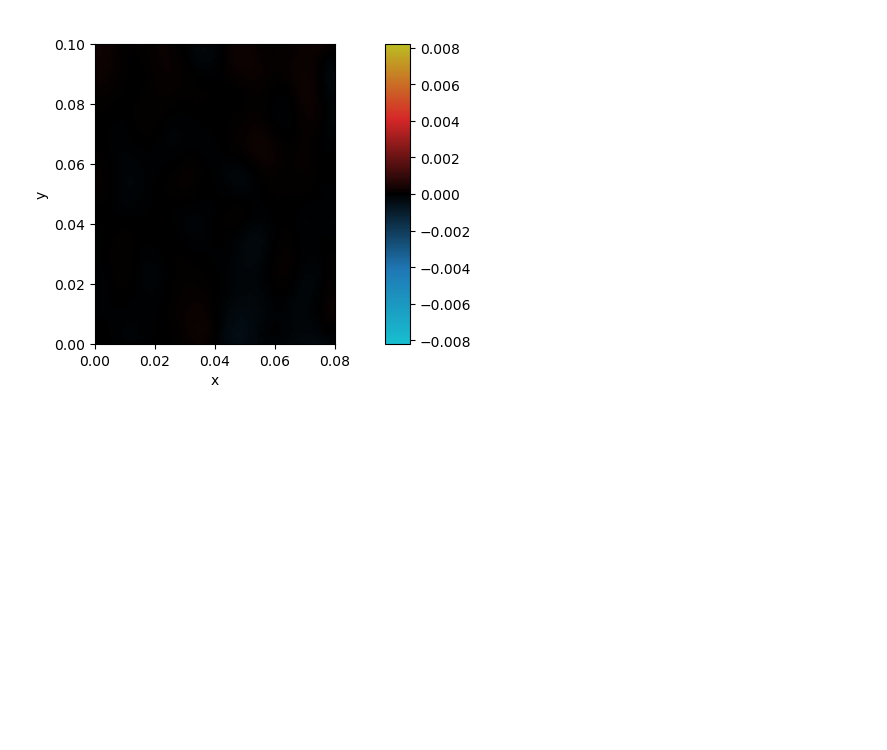

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [4]:
frequency = 90 # Hz
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box', frequency)
example.view('wave', ax_height=3)

In [5]:
example.metadata

size  spacing  \
variable dimension                  
wave     x            80    0.001   
         y           100    0.001   
         z            10    0.001   
mre      x            80    0.001   
         y           100    0.001   
         z            10    0.001   
mre_mask x            80    0.001   
         y           100    0.001   
         z            10    0.001   

                                                               origin  \
variable dimension                                                      
wave     x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.)\...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.)\...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.)\...   
mre      x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.)\...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.)\...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.)\...   
mre_mask x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.)\...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.)\...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.)\...   

                                                                limit  \
variable dimension                                                      
wave     x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.07...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.09...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   
mre      x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.07...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.09...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   
mre_mask x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.07...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.09...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   

                                                               center  \
variable dimension                                                      
wave     x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   
mre      x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   
mre_mask x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...   
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...   
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...   

                                                               extent  
variable dimension                                                     
wave     x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.08...  
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.1)...  
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.01...  
mre      x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.08...  
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.1)...  
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.01...  
mre_mask x          <xarray.DataArray 'x' ()> Size: 8B\narray(0.08...  
         y          <xarray.DataArray 'y' ()> Size: 8B\narray(0.1)...  
         z          <xarray.DataArray 'z' ()> Size: 8B\narray(0.01...

In [6]:
example.describe()

dtype    count                      mean  \
variable component                                                  
wave     y          complex128  80000.0    -0.000001-   0.000005j   
         x          complex128  80000.0     0.000079-   0.000073j   
         z          complex128  80000.0    -0.000287-   0.000249j   
mre      scalar     complex128  80000.0  3382.375000+ 565.486678j   
mre_mask scalar          int32  80000.0     1.076500+   0.000000j   

                            std                       min  \
variable component                                          
wave     y             0.000241    -0.000499-   0.000196j   
         x             0.000346    -0.000905+   0.000477j   
         z             0.004918    -0.011268-   0.002122j   
mre      scalar     1590.727619  3000.000000+ 565.486678j   
mre_mask scalar        0.362143     1.000000+   0.000000j   

                                         25%  \
variable component                             
wave     y            -0.000058+   0.000031j   
         x            -0.000015-   0.000234j   
         z            -0.002060-   0.001419j   
mre      scalar     3000.000000+ 565.486678j   
mre_mask scalar        1.000000+   0.000000j   

                                                               50%  \
variable component                                                   
wave     y         -2.027842e-06+1.385699e-                    07j   
         x          6.278027e-05+1.562524e-                    05j   
         z         -7.380324e-12-7.602312e-                    11j   
mre      scalar     3.000000e+03+5.654867e+                    02j   
mre_mask scalar     1.000000e+00+0.000000e+                    00j   

                                         75%                         max  
variable component                                                        
wave     y             0.000062-   0.000136j      0.000474+    0.000099j  
         x             0.000169-   0.000225j      0.001094-    0.000011j  
         z             0.001818-   0.001513j      0.008730+    0.001950j  
mre      scalar     3000.000000+ 565.486678j  10000.000000+  565.486678j  
mre_mask scalar        1.000000+   0.000000j      5.000000+    0.000000j

Visualize ground truth elasticity map along with AHI and FEM-based elasticity reconstruction methods.

Evaluating direct baseline


<IPython.core.display.Javascript object>


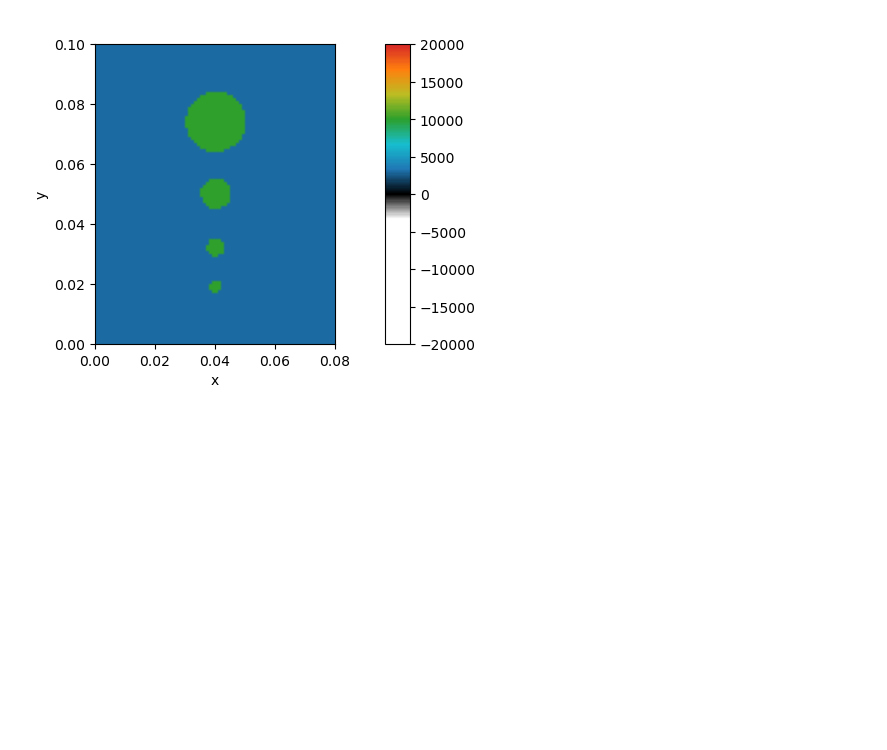

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


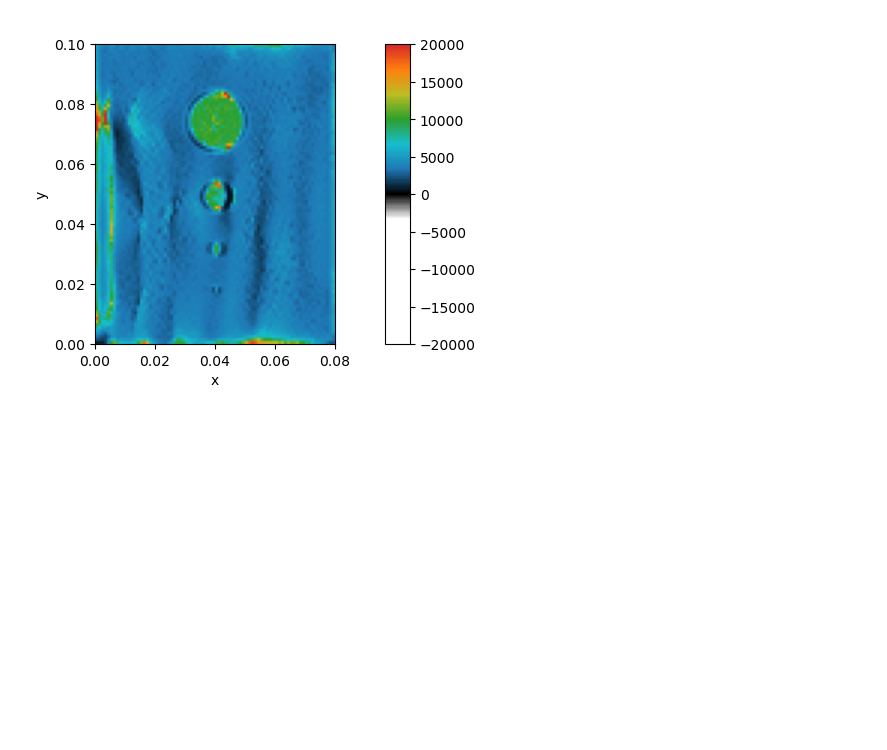

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [7]:
mre_pinn.baseline.eval_ahi_baseline(example, frequency=frequency)
#mre_pinn.baseline.eval_fem_baseline(example, frequency=frequency, hetero=False)
example.view('mre', 'direct', ax_height=3, polar=True, vmax=20e3)

Construct the PDE and PINN architecture that will be used to solve it.

In [8]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=frequency)

In [9]:
# Check what's in the metadata
print(example.metadata['center'])
print(type(example.metadata['center'].wave.values))
print(example.metadata['center'].wave.values)

variable  dimension
wave      x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...
          z            <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...
mre       x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...
          z            <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...
mre_mask  x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...
          z            <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...
Lu        x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.DataArray 'y' ()> Size: 8B\narray(0.04...
          z            <xarray.DataArray 'z' ()> Size: 8B\narray(0.00...
direct    x            <xarray.DataArray 'x' ()> Size: 8B\narray(0.03...
          y            <xarray.

In [10]:
pinn = mre_pinn.model.MREPINN(
    example,
    omega=60,
    n_layers=2,
    n_hidden=64,
    activ_fn='ss', # sin
    polar_input=False
)
pinn

C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\model\pinn.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.u_loc = torch.tensor(stats['mean'].wave)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\model\pinn.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.u_scale = torch.tensor(stats['std'].wave)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\model\pinn.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=64, bias=True)
    (output): Linear(in_features=67, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=64, bias=True)
    (output): Linear(in_features=67, out_features=2, bias=True)
  )
)

Compile the PINN model and specify training hyperparameters.

In [11]:
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 0, 1e-8],
    pde_warmup_iters=10,
    pde_step_iters=5,
    pde_step_factor=1,
    pde_init_weight=1e-10,
    n_points=1024,
    device = 'cpu'
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000512 s



Perform model forward-backward pass benchmarking to estimate training time.

In [12]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(10)

# iterations: 10
Data time/iter:  0.0183s (6.23%)
Model time/iter: 0.0067s (2.28%)
Loss time/iter:  0.2689s (91.49%)
Total time/iter: 0.2940s
Total time: 2.9395s
1k iters time: 4.90m
10k iters time: 48.99m
100k iters time: 8.17h


Create test evaluator that will be used to periodically evaluate and visualize model output on full spatial domain. The visualizers should update automatically once the training loop begins. Note that the interactive sliders can be used to adjust what slice of the images are visualized, but these do not work while the training loop is running.

<IPython.core.display.Javascript object>


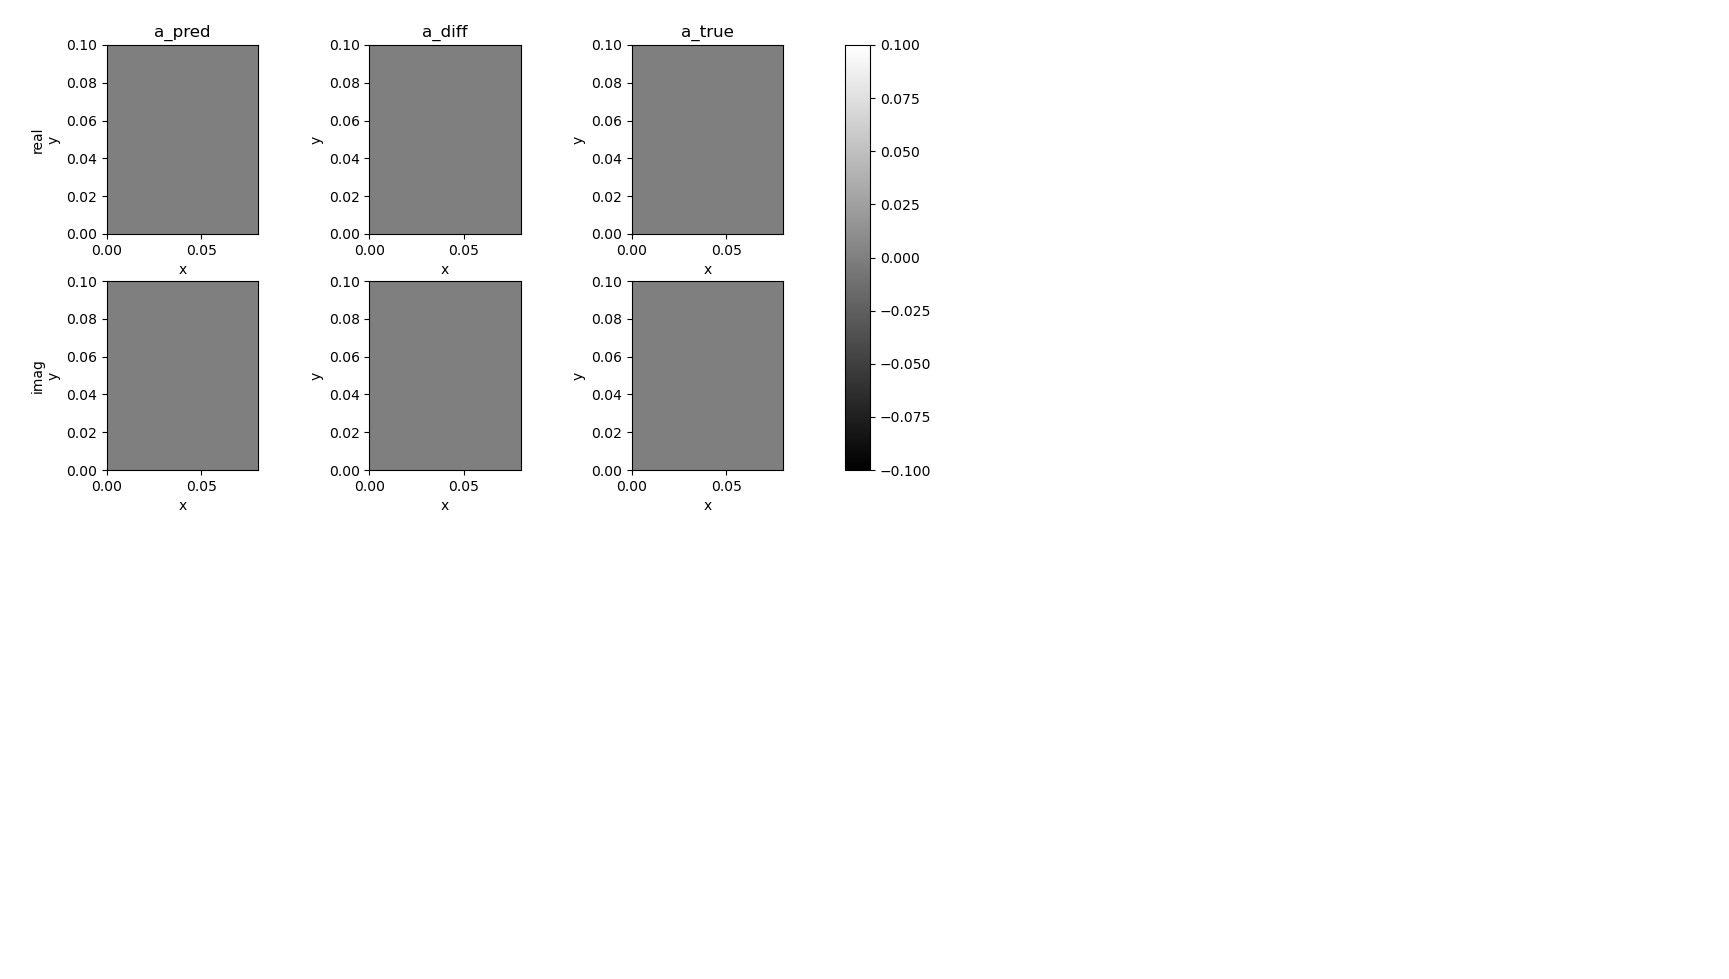

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


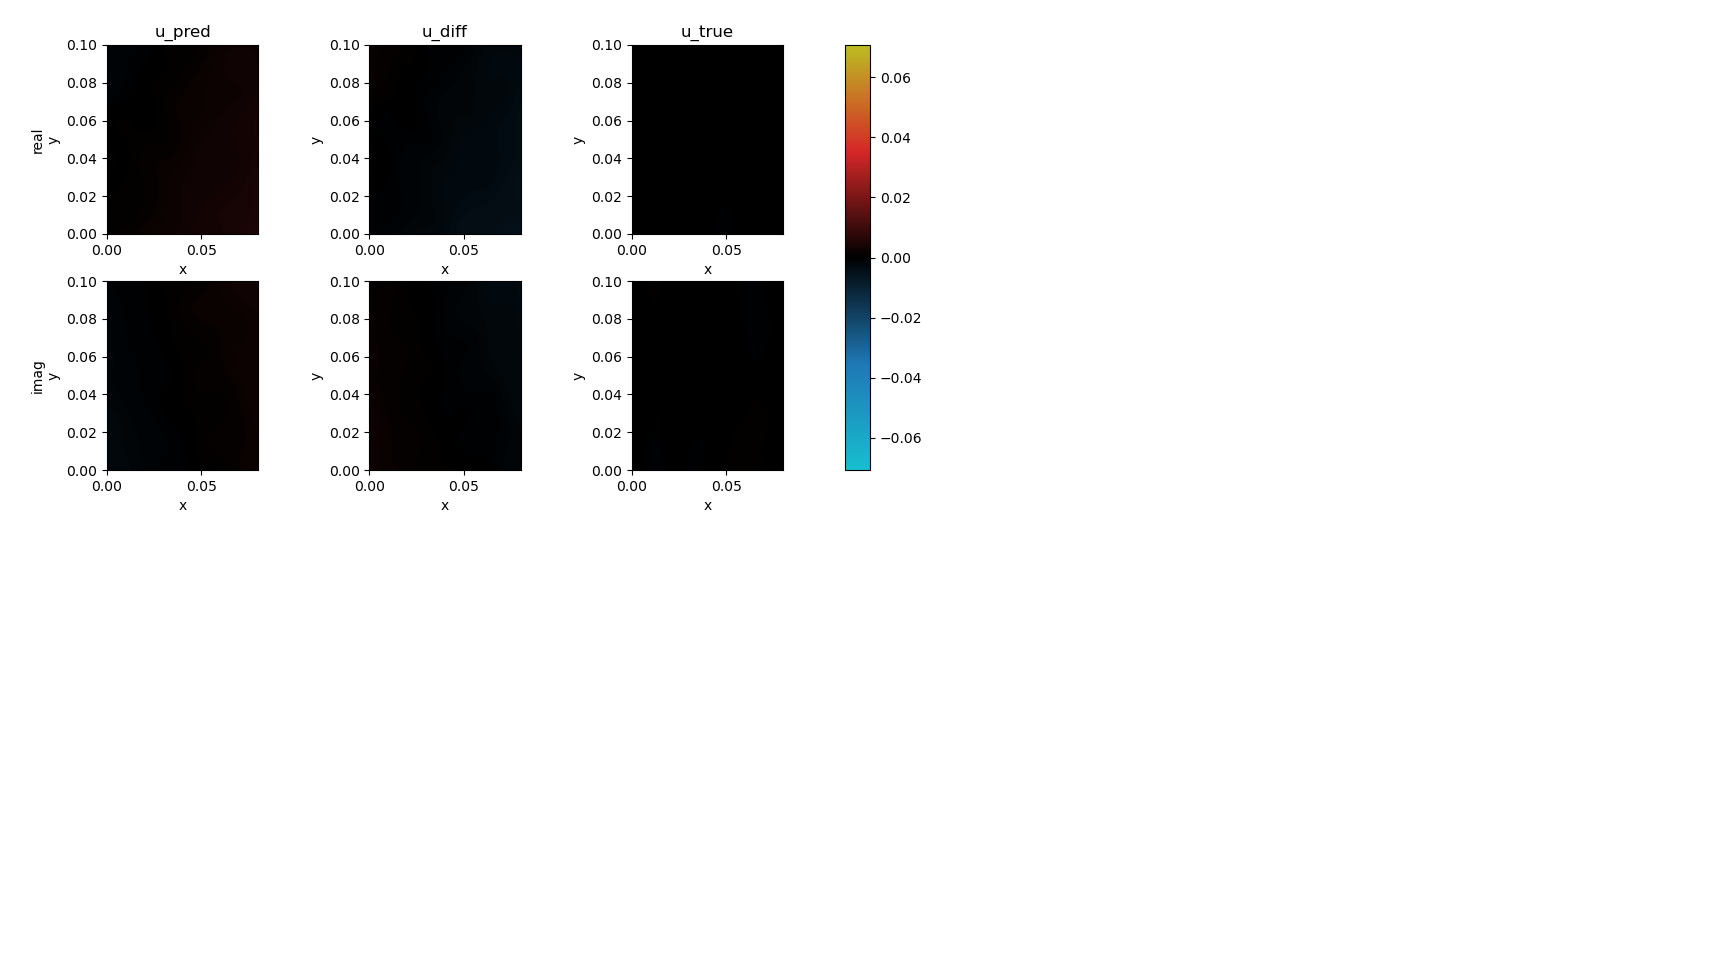

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


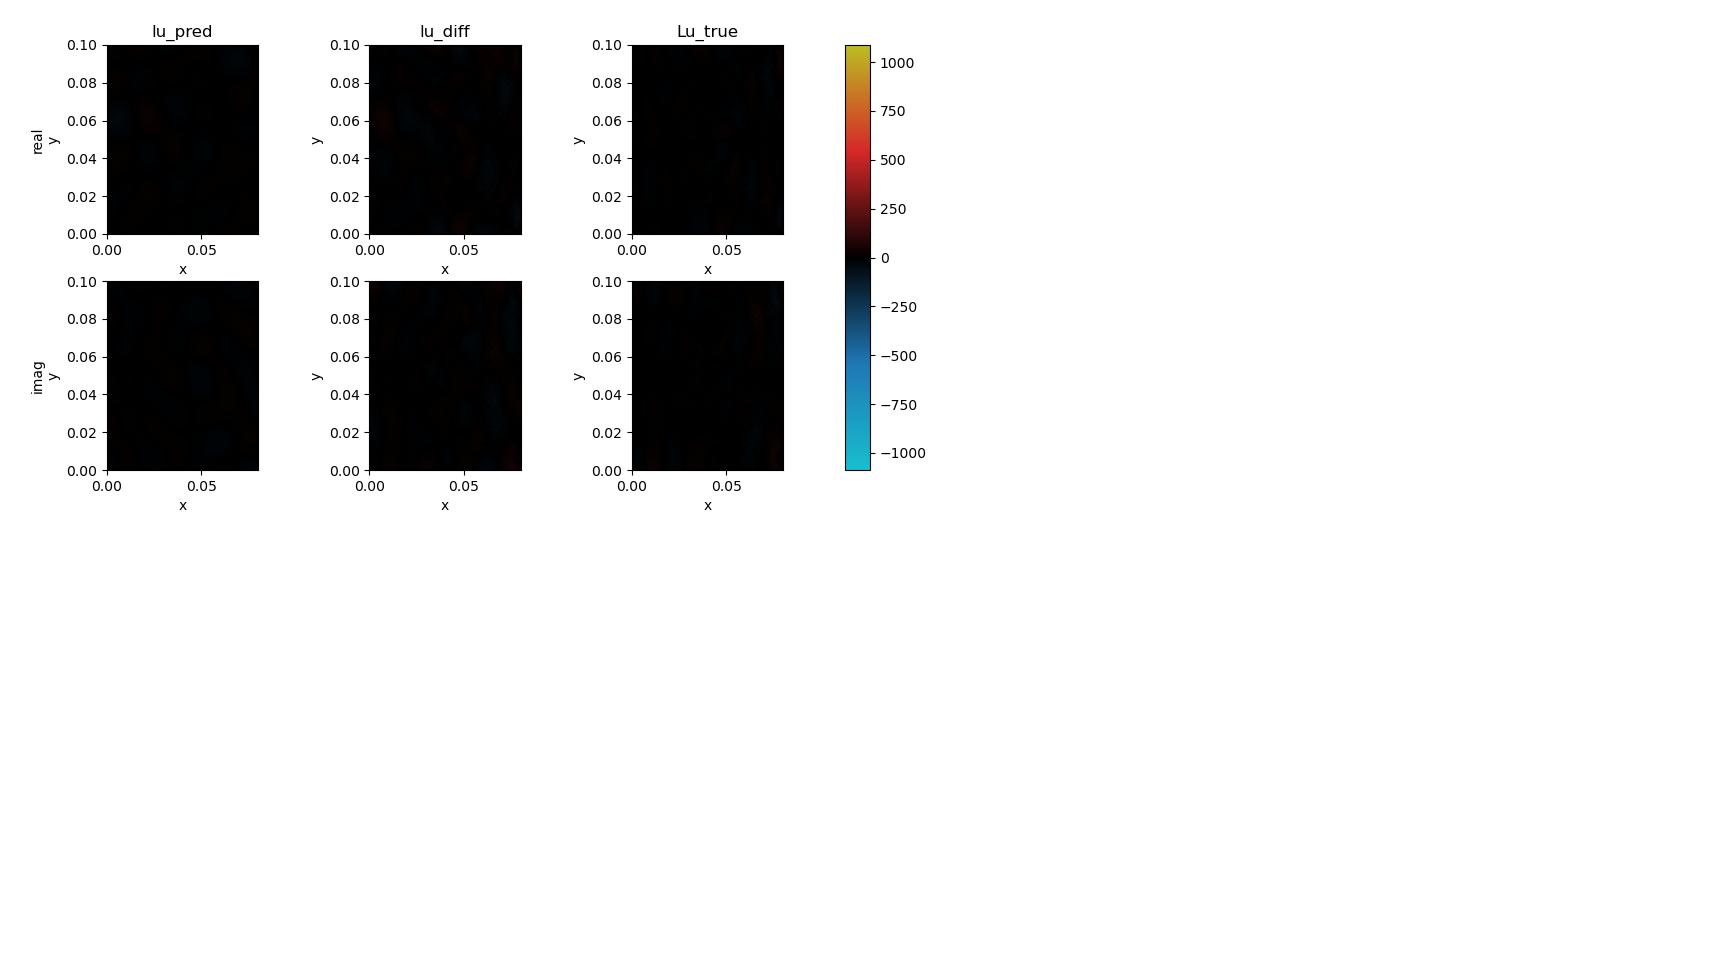

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


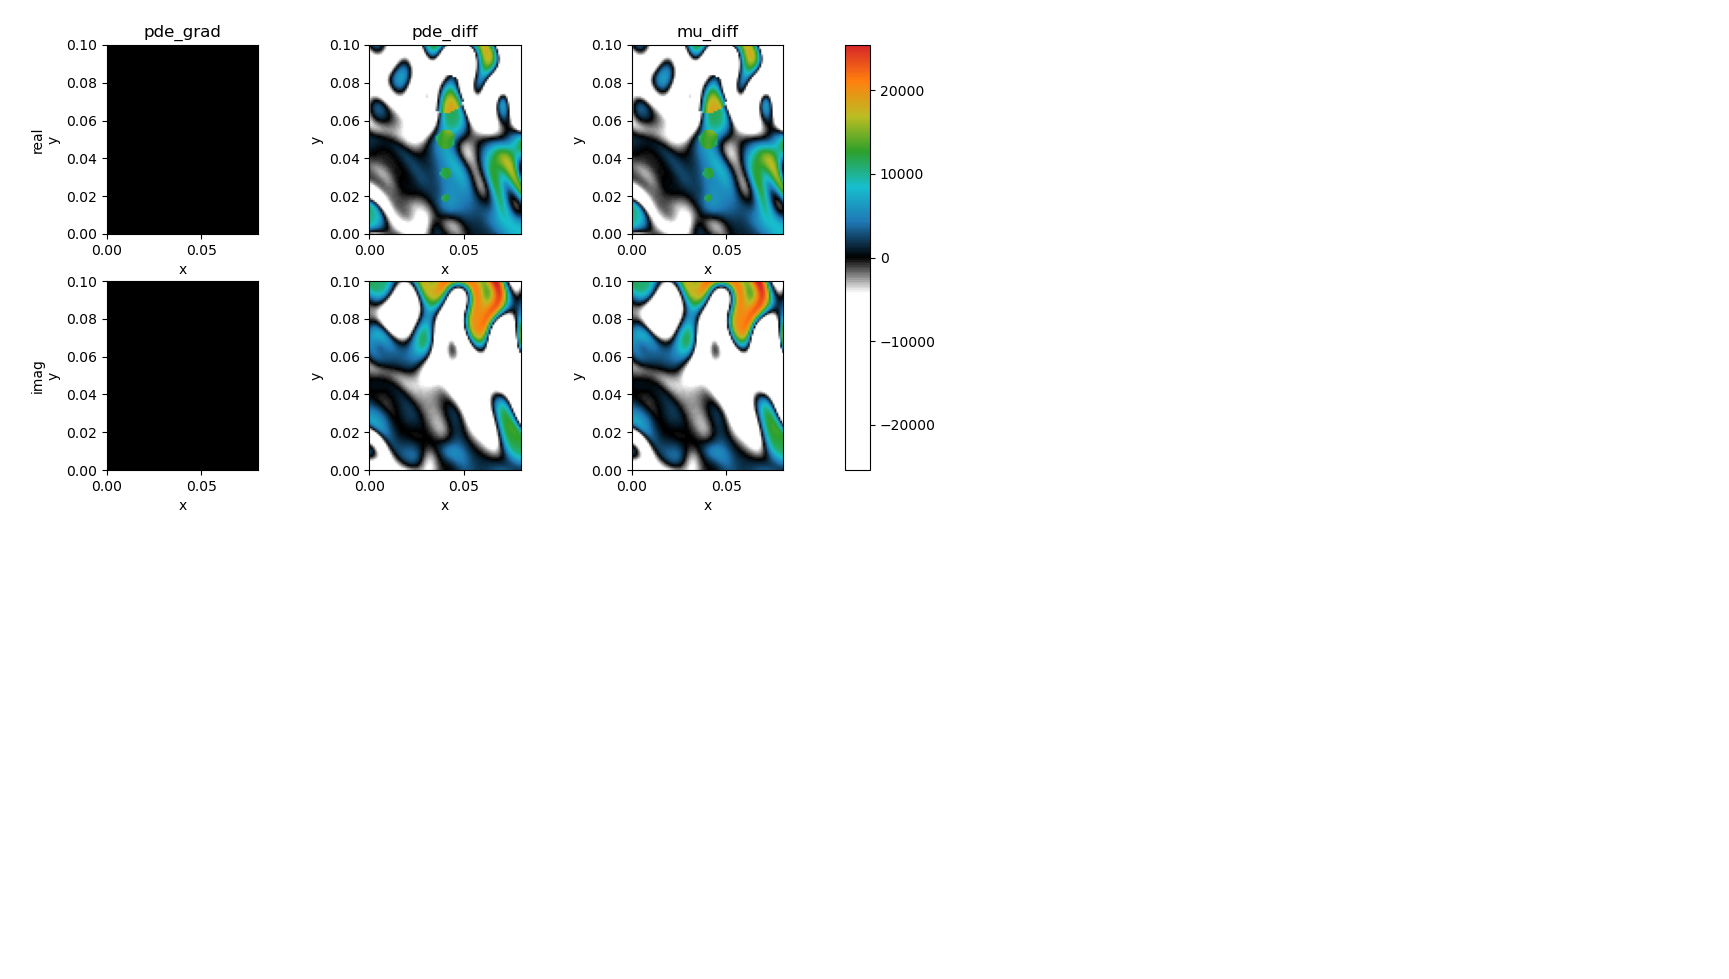

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


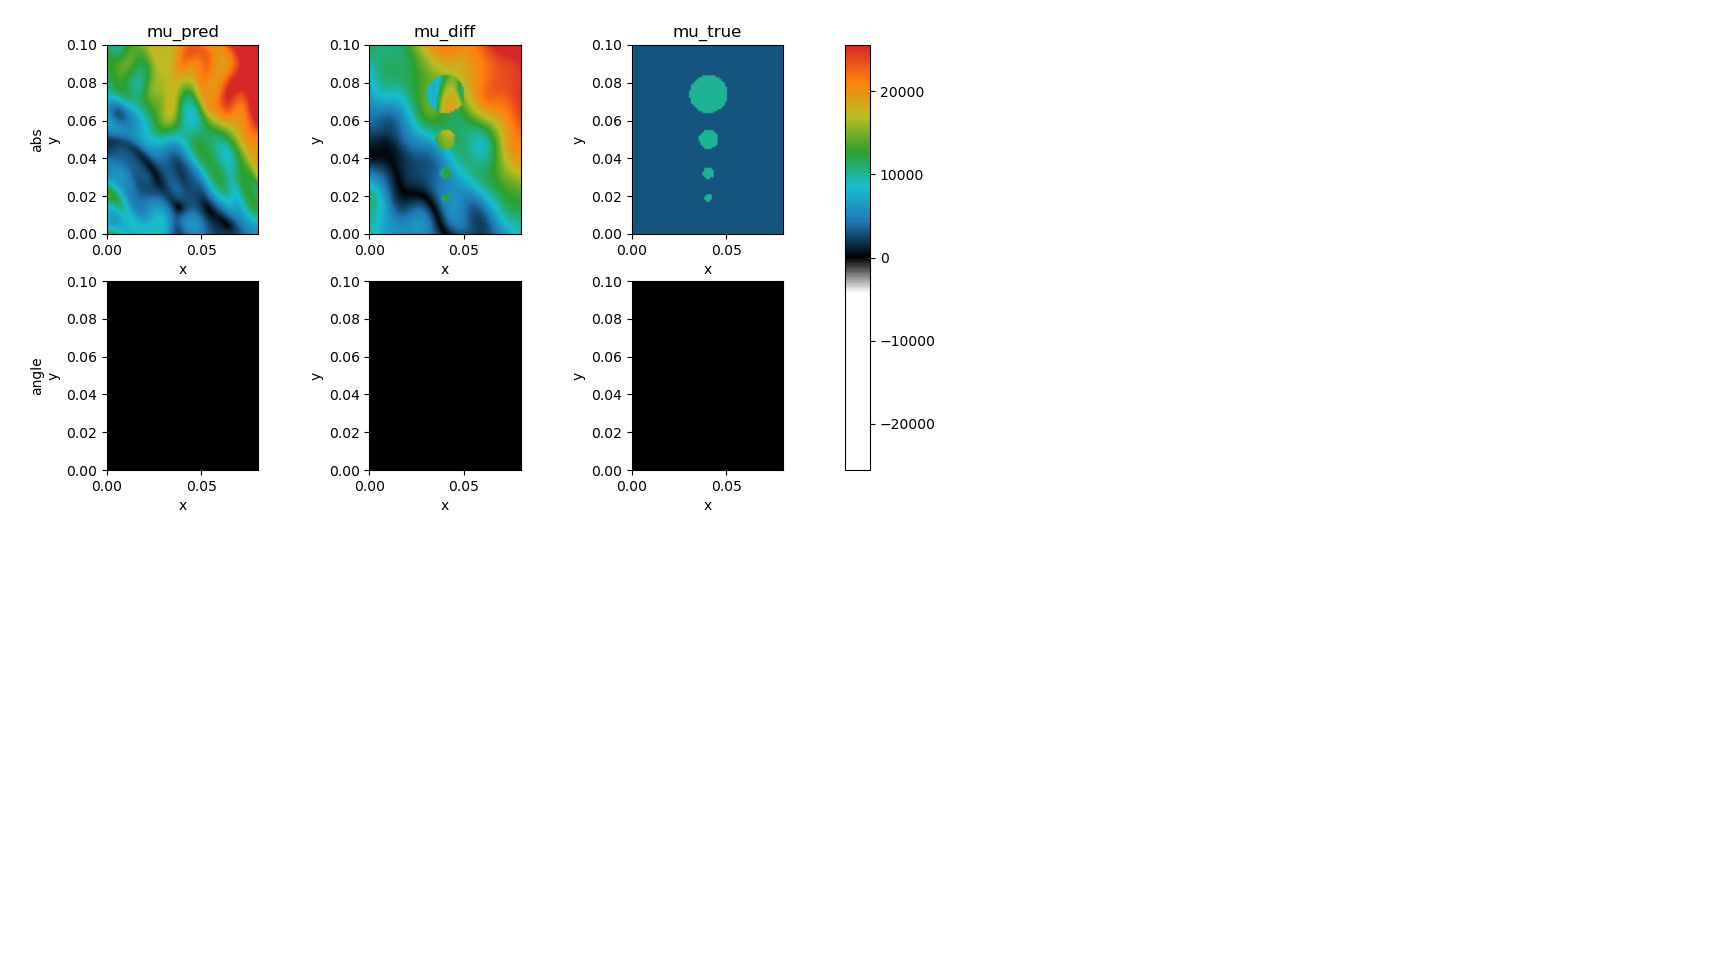

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


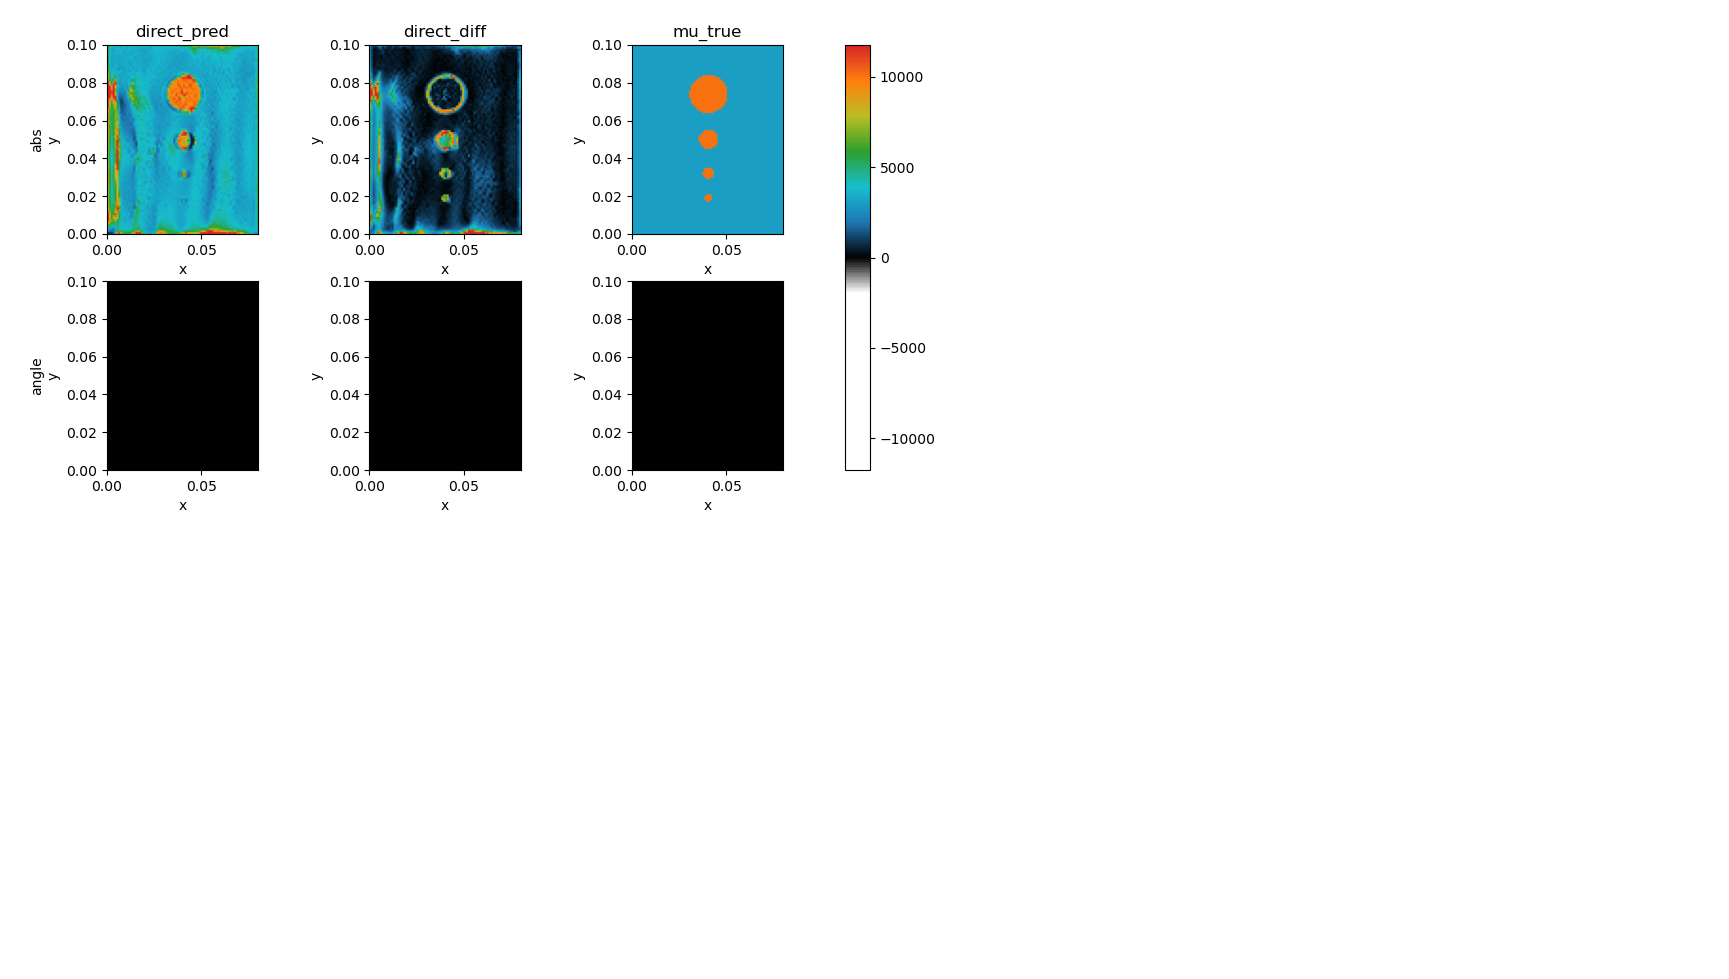

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [13]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=1, save_every=2, save_prefix='DEMO', interact=True)
test_eval.model = model
test_eval.test()

Run the training loop.

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.66e-04, 0.00e+00, 0.00e+00, 0.00e+00]    [5.64e-04, 0.00e+00, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


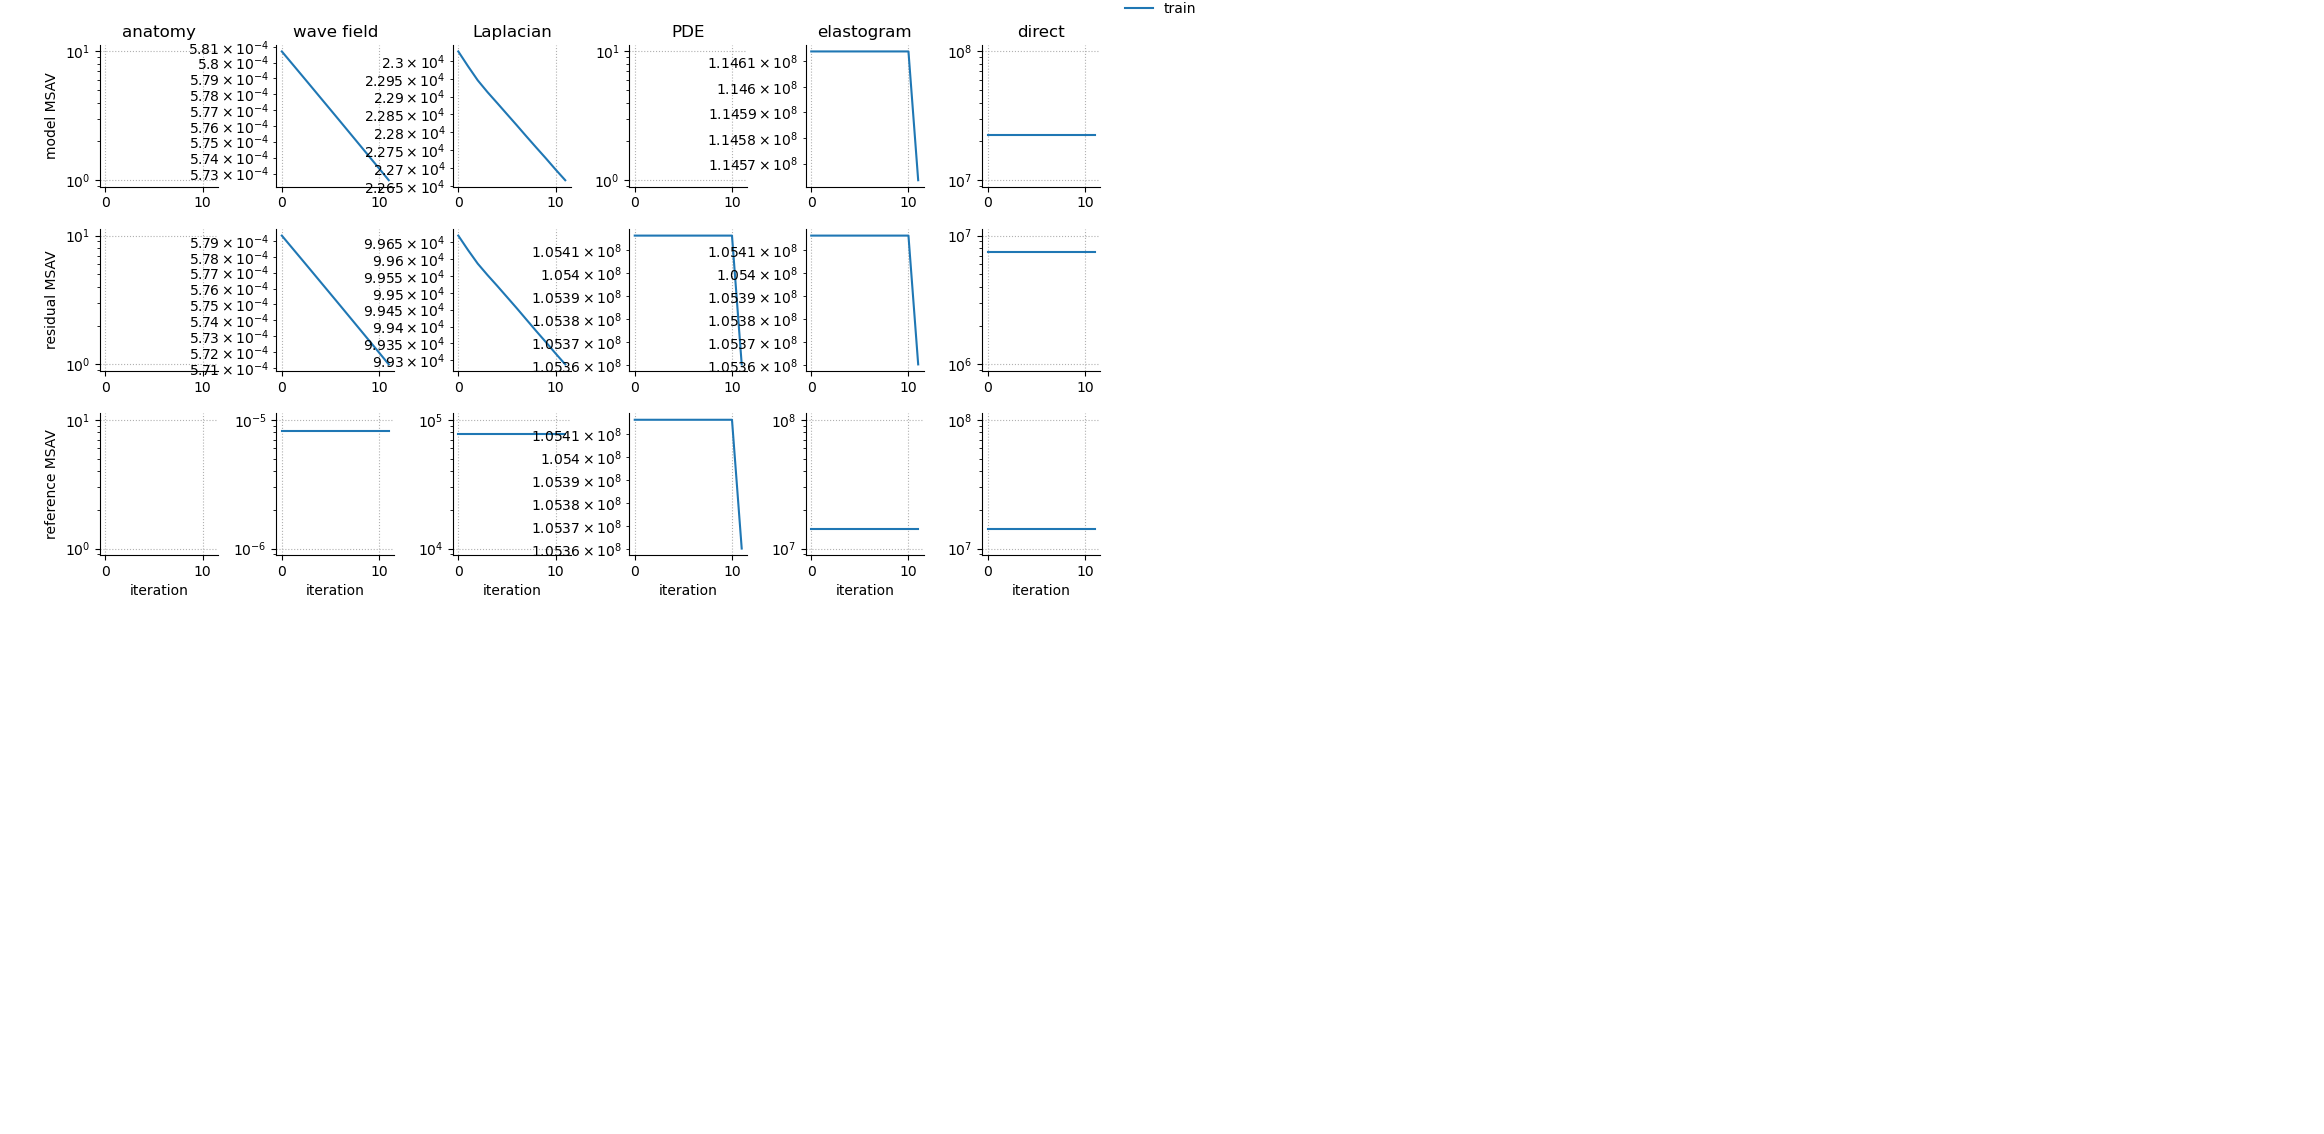

C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)


<IPython.core.display.Javascript object>


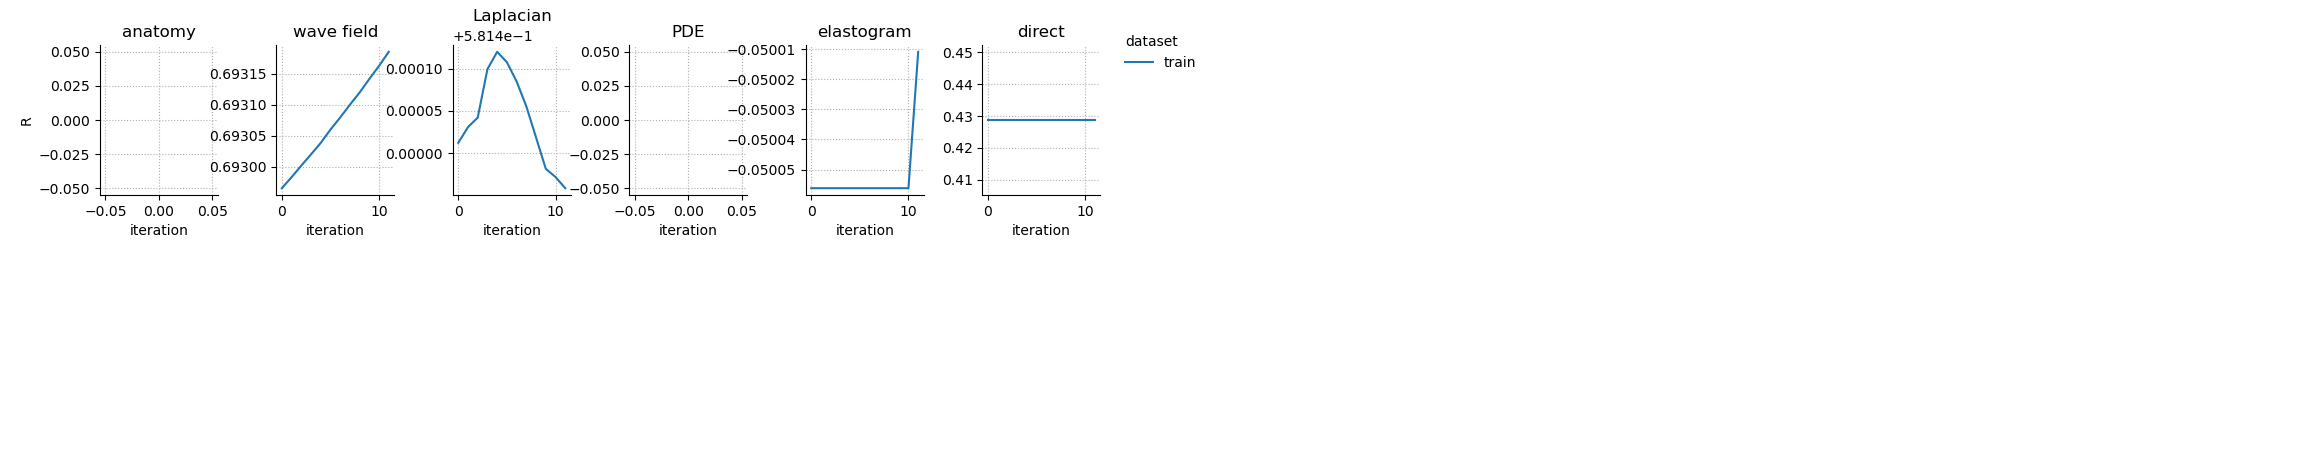

<IPython.core.display.Javascript object>


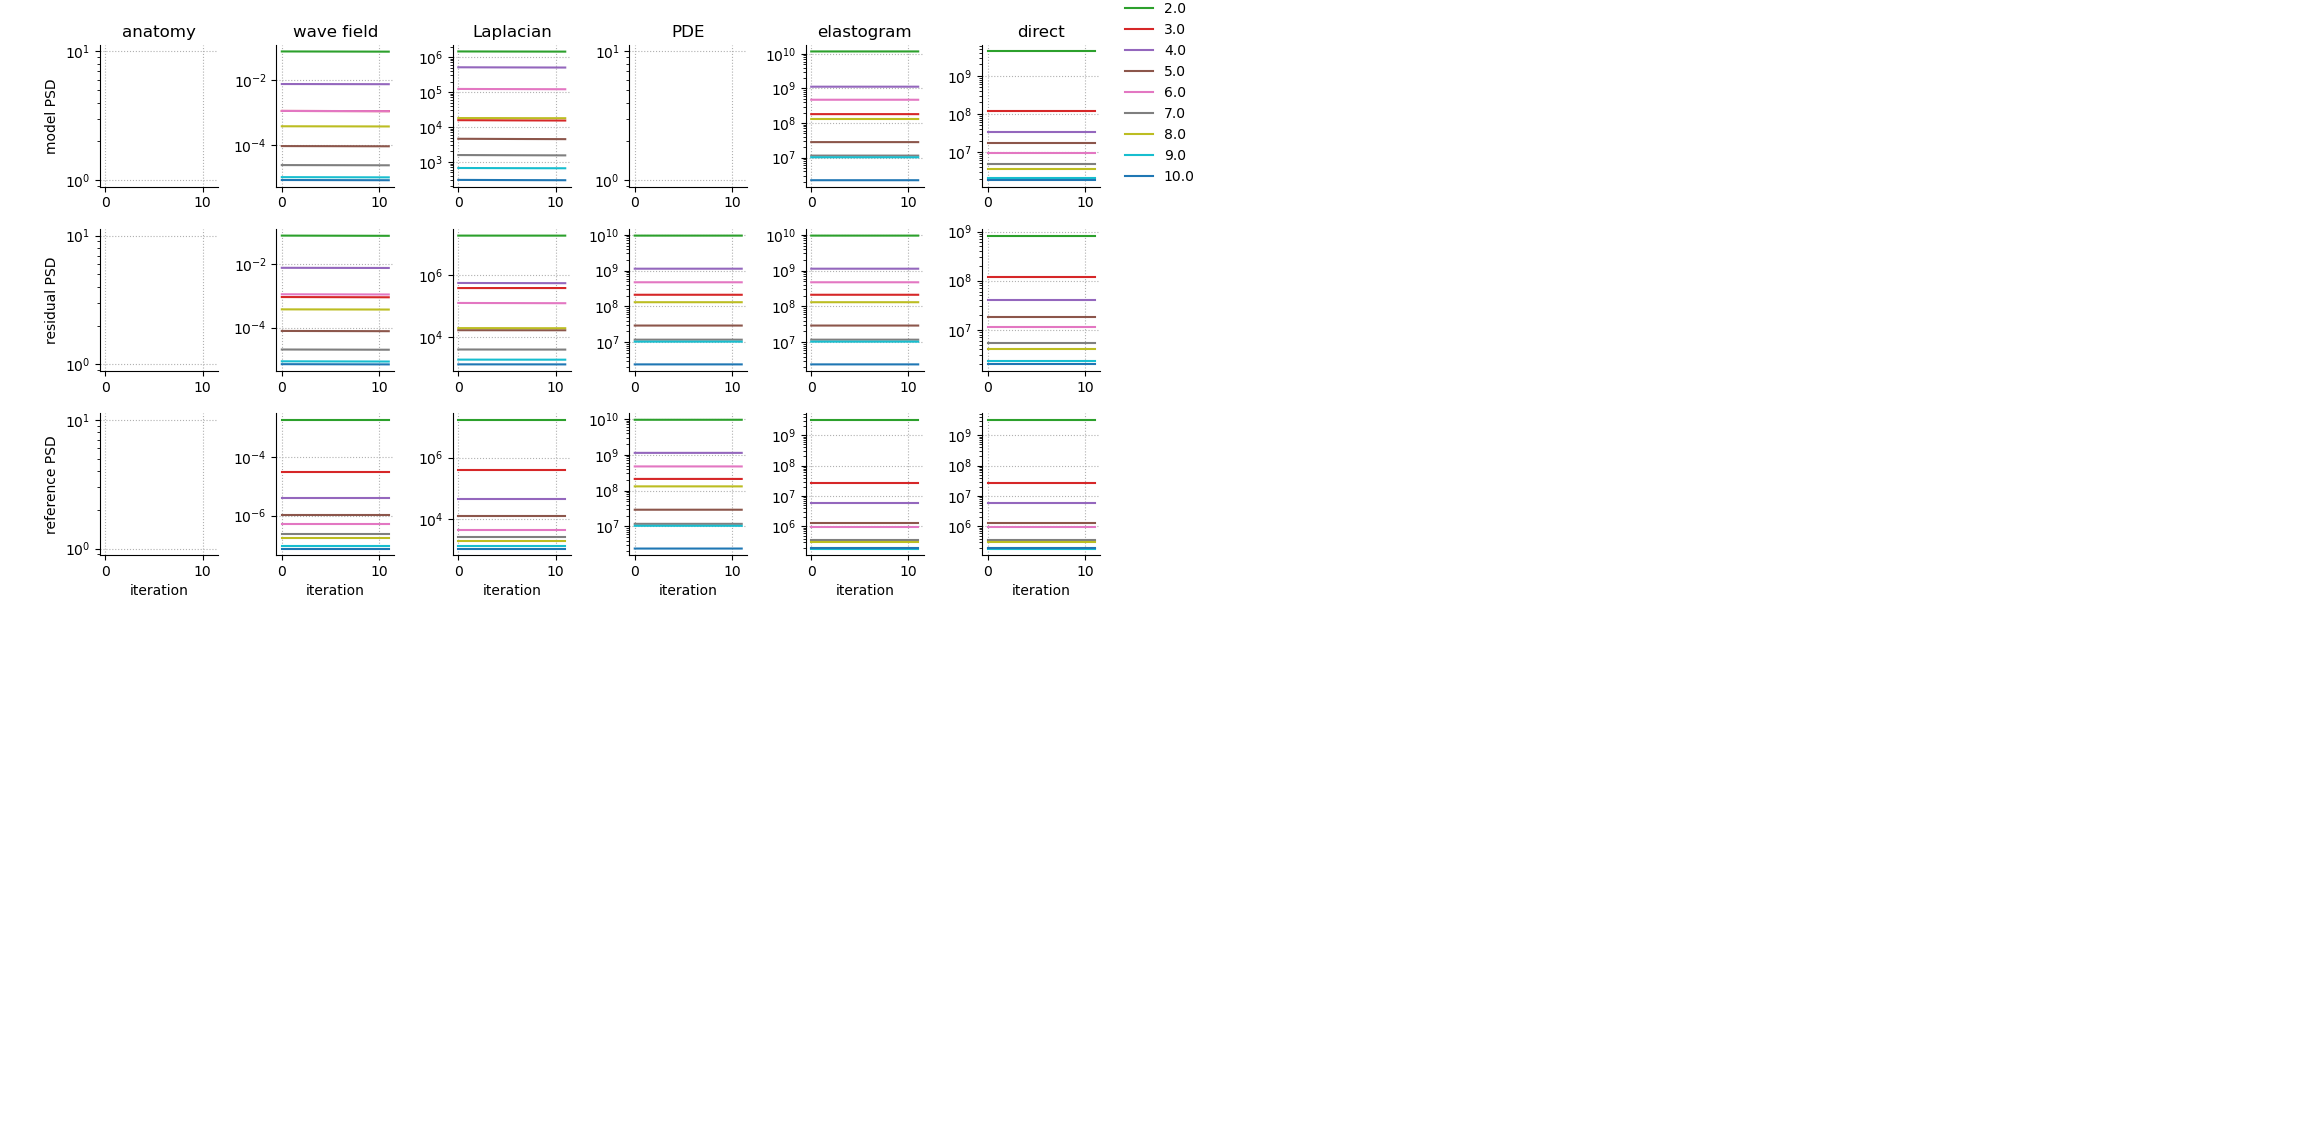

C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)


<IPython.core.display.Javascript object>


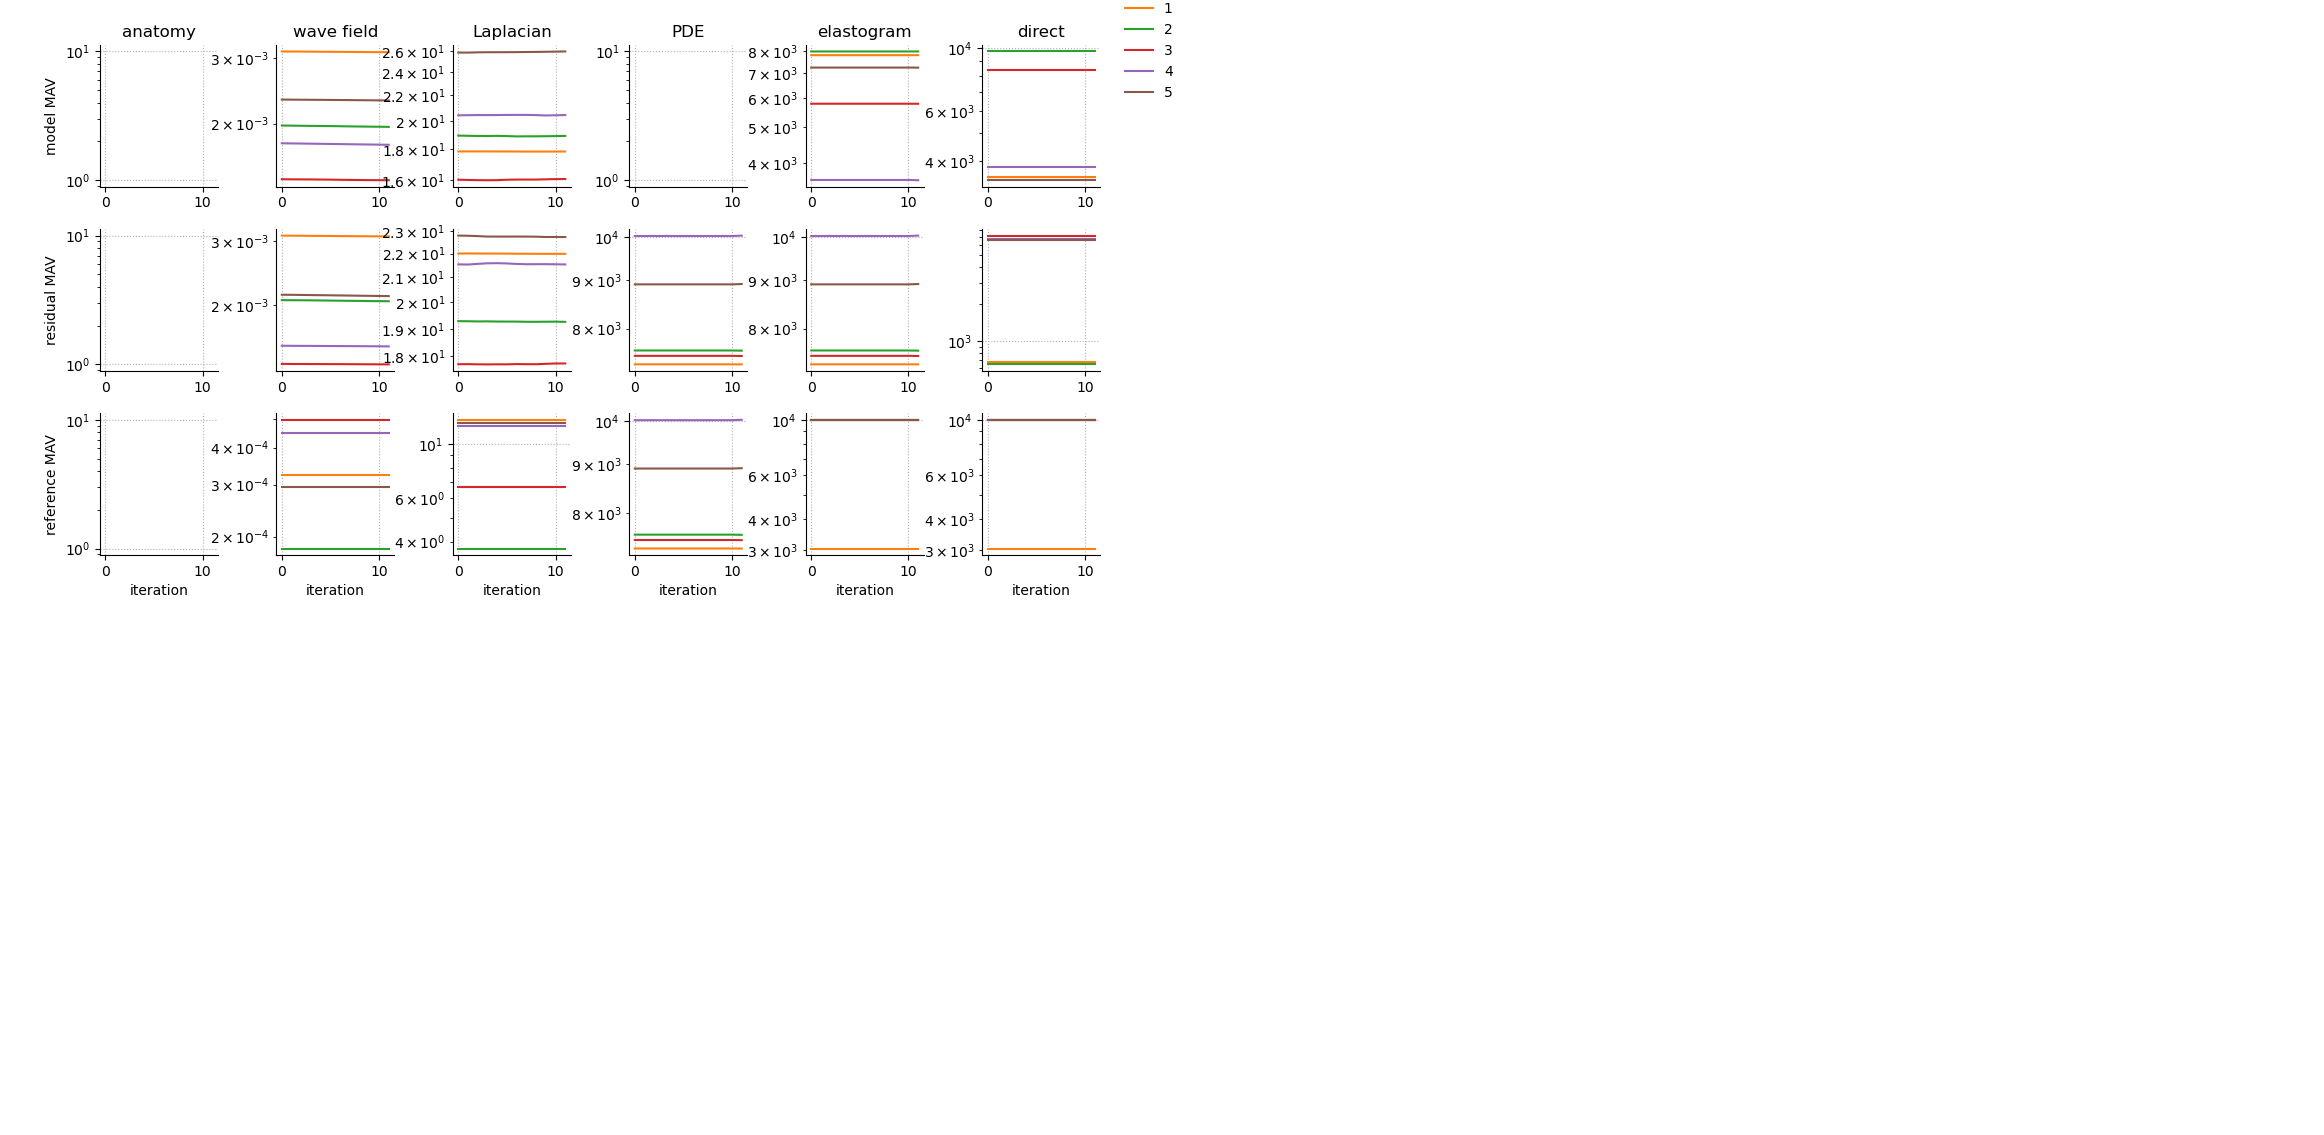

C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:485: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(yscale)


Time spent testing: 70.6826 (57.07%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 34.0139 (66.23%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 28.4292 (71.35%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 27.0169 (74.94%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 31.9950 (78.18%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 38.2962 (81.10%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 35.6437 (83.18%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 40.8635 (85.03%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 72.0041 (87.48%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 61.9573 (88.99%)
10        [5.64e-04, 0.00e+00, 0.00e+00, 6.47e+03]    [5.57e-04, 0.00e+00, 0.00e+00, 6.40e+03]    []  


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 50.9252 (89.94%)


C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MRE-PINN\MICCAI-2023\..\mre_pinn\visual.py:470: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  self.axes[i,j].autoscale_view()
C:\Users\Yeshwanth Kesav\Desktop\MR

Time spent testing: 38.0255 (90.57%)


In [ ]:
%%time
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
model.train(100, display_every=10, callbacks=[test_eval])
if torch.cuda.is_available():
    print(f"Peak GPU memory: {torch.cuda.max_memory_allocated() / 2**30:.2f} GiB")
else:
    print("CUDA not available - memory stats not tracked")

In [ ]:
test_eval.test()

In [ ]:
test_eval.metrics